#### Noisy Quantum SVM - New Try

In [41]:
import qiskit, qiskit_aer, qiskit_machine_learning
print("Qiskit:", qiskit.__version__)
print("Aer:", qiskit_aer.__version__)
print("QML:", qiskit_machine_learning.__version__)

Qiskit: 1.4.4
Aer: 0.17.2
QML: 0.8.4


In [42]:
# To ensure reproducibility of results
from qiskit_machine_learning.utils import algorithm_globals
algorithm_globals.random_seed = 12345

In [43]:
# Imports
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [44]:
# --- Qiskit Imports ---
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

from qiskit_aer.primitives import SamplerV2 as AerSampler
# from qiskit.primitives import Samplerv2 

from qiskit.circuit.library import ZZFeatureMap

# Qiskit machine learning
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

# For transpilation
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Getting realistic noise model
# from qiskit_ibm_runtime.fake_provider import FakeManilaV2
# from qiskit_ibm_runtime import QiskitRuntimeService

In [45]:
# Load data first
lung_cancer_column_names = ['label'] + [f'attr_{i}' for i in range(1, 57)]
file_path_lung = r'C:\Users\User\Documents\MyProjects\FYP_ResearchProject\data\lung+cancer\lung-cancer.data'

# reads the data, treating "?" as missing values
df_lung = pd.read_csv(file_path_lung, header=None, names=lung_cancer_column_names, na_values=['?'])

print(f"Original shape of Lung Cancer data: {df_lung.shape}")

Original shape of Lung Cancer data: (32, 57)


In [46]:
# Mode imputation for missing values
modes = df_lung.mode().iloc[0]
df_lung.fillna(modes, inplace=True)

# Then check if all Nan are gone
print(f"Total missing values after imputation: {df_lung.isnull().sum().sum()}\n")

Total missing values after imputation: 0



In [47]:
df_lung['label_binary'] = df_lung['label'].apply(lambda x: 0 if x == 1 else 1)

In [48]:
X_lung = df_lung.drop(['label', 'label_binary'], axis=1)
y_lung_binary = df_lung['label_binary']

In [49]:
# Train-test split
X_train_lc, X_test_lc, y_train_lc, y_test_lc = train_test_split(
    X_lung, y_lung_binary, test_size=0.3, random_state=42, stratify=y_lung_binary
)

In [50]:
# One-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_lc_encoded = pd.DataFrame(encoder.fit_transform(X_train_lc), columns=encoder.get_feature_names_out())
X_test_lc_encoded = pd.DataFrame(encoder.transform(X_test_lc), columns=encoder.get_feature_names_out())

In [51]:
# Feature selection with Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0: 
        return 0
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_scores = {col: cramers_v(X_train_lc_encoded[col], y_train_lc) for col in X_train_lc_encoded.columns}
cramers_series = pd.Series(cramers_scores).sort_values(ascending=False)

N_FEATURES_TO_SELECT = 10
top_features = cramers_series.head(N_FEATURES_TO_SELECT).index.tolist()

X_train_lc_final = X_train_lc_encoded[top_features]
X_test_lc_final = X_test_lc_encoded[top_features]

print("--- Data Preprocessing Complete ---")
print(f"Final training data shape: {X_train_lc_final.shape}")
print(f"Final testing data shape: {X_test_lc_final.shape}\n")

--- Data Preprocessing Complete ---
Final training data shape: (22, 10)
Final testing data shape: (10, 10)



##### Setup Noise Model 

In [52]:
# Noise Model implementation from (Depolarizing error and Readout Error)
print("--- Setting up Noise Model ---")
# Error rates (realistic, not too high)
p_gate_1q = 0.001   # 0.1% error for single-qubit gates (u1, u2, u3)
p_gate_2q = 0.01    # 1.0% error for two-qubit gates (cx)
p_readout = 0.02    # 2.0% chance of wrong measurement

# Build the noise model
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(p_gate_1q, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p_gate_2q, 2), ['cx'])

# Add readout error (0 -> 1 or 1 -> 0)
readout_error = ReadoutError([[1 - p_readout, p_readout], [p_readout, 1 - p_readout]])
noise_model.add_all_qubit_readout_error(readout_error, ['measure'])

--- Setting up Noise Model ---


In [53]:
# Create Noise Sampler
# noise_sampler = AerSampler(
#     # default_shots=8192,
#     default_shots=1024,
#     options={
#         "backend_options": {
#             "noise_model": noise_model
#         }
#     }
# )

In [54]:
# Using Base AerSimulator
# aer_backend = AerSimulator()

# Creating a TRANSPILATION MANAGER
# This ensures all circuits are converted into the native gates (basis gates)
# the simulator and noise model use.
# optimization_level=1 is will be a good starting point for balancing speed and circuit quality.
# pm = generate_preset_pass_manager(optimization_level=1, backend=aer_backend)

# feature_dim = N_FEATURES_TO_SELECT
# fm = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')

# Reinstantiate the ComputeUncompute and then passing the pass_manager
# fidelity = ComputeUncompute(sampler=noise_sampler, pass_manager=pm)
# qkernel_noisy = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm)

In [55]:
noisy_backend = AerSimulator(
    noise_model=noise_model,
    seed_simulator=12345,
)

noise_sampler = AerSampler.from_backend(
    backend=noisy_backend,
    default_shots=8192,  # 8192 is good for QSVM; adjust if too slow
)

print("Noisy SamplerV2 ready for QSVM training!")

Noisy SamplerV2 ready for QSVM training!


In [56]:
# Transpilation pass manager
pm = generate_preset_pass_manager(optimization_level=1, backend=noisy_backend)

print ("Realistic noise model applied !")

Realistic noise model applied !


##### Quantum Kernel Implementation

In [57]:
feature_dim = N_FEATURES_TO_SELECT
fm = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')

# Fidelity with noisy sampler and transpilation
fidelity = ComputeUncompute(sampler=noise_sampler, pass_manager=pm)

# Noisy quantum kernel
quantum_kernel_noisy = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm)

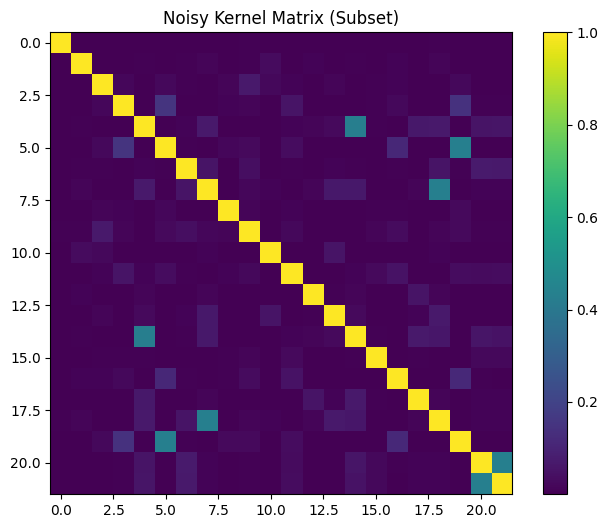

In [58]:
# Plotting noisy kernel matrix
matrix_train_noisy = quantum_kernel_noisy.evaluate(x_vec=X_train_lc_final[:50])  # Subset for plot if too large
plt.figure(figsize=(8, 6))
plt.imshow(matrix_train_noisy, cmap='viridis')
plt.title("Noisy Kernel Matrix (Subset)")
plt.colorbar()
plt.show()

In [59]:
# Ideal QSVC with tuned parameters
print("--- Training Ideal QSVC (Lung Cancer) ---")
start_time = time.time()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'class_weight': ['balanced']      # <<< keep this
}

# Use cross-validation suitable for small/imbalanced data
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# qsvc_ideal = QSVC(quantum_kernel=qkernel, C=1, class_weight='balanced')
# Grid search on QSVC
grid_search = GridSearchCV(
    QSVC(quantum_kernel=quantum_kernel_noisy, class_weight='balanced'),  # Your QSVC setup
    param_grid,
    cv=cv,
    scoring='accuracy',  # Or 'f1_macro' for imbalanced classes
    n_jobs = -1,
    verbose=1  # For progress output
)

# start_time = time.time()
# qsvc_ideal.fit(X_train_lc_final, y_train_lc)
# end_time = time.time()
# print(f"QSVC training finished in {end_time - start_time:.2f} seconds.")
# Fit (this will take time due to quantum kernel evaluations)

--- Training Ideal QSVC (Lung Cancer) ---


In [ ]:
grid_search.fit(X_train_lc_final, y_train_lc)
qsvc_noisy = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
end_time = time.time()
print(f"QSVC training finished in {end_time - start_time:.2f} seconds.")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [ ]:
y_train_pred = qsvc_noisy.predict(X_train_lc_final)
train_accuracy = accuracy_score(y_train_lc, y_train_pred)

y_test_pred = qsvc_noisy.predict(X_test_lc_final)
test_accuracy = accuracy_score(y_test_lc, y_test_pred)

generalization_gap = abs(train_accuracy - test_accuracy)

print(f"\n--- Noisy QSVM Evaluation (Lung Cancer) ---")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")
print(f"Generalization Gap: {generalization_gap:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test_lc, y_test_pred, zero_division=0))


--- Noisy QSVM Evaluation (Lung Cancer) ---
Training Accuracy: 1.0000
Test Accuracy:     0.7000
Generalization Gap: 0.3000

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.70      1.00      0.82         7

    accuracy                           0.70        10
   macro avg       0.35      0.50      0.41        10
weighted avg       0.49      0.70      0.58        10

